In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import demoji

# Data Import

In [2]:
#df_train_raw = pd.read_excel('Project Corpora/train.xlsx')
df = pd.read_csv('output/train_with_translation.csv') # this is the result of translation of descriptions
df.head(5)

,index,description,host_about,unlisted,description_language,host_about_language,description_english
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"This is a shared mixed room in our hostel, wit..."
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,"My space is close to Parque Eduardo VII, Salda..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,Trafaria’s House is a cozy and familiar villa ...
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!\nI m Portuguese and i love to meet peop...,0,pt,en,"Charming apartment in Chiado, Between the Farg..."
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr,Beautiful apartment on the beach.<br /> 2 min....


# Preprocesssing

## Splitting data into Train and Validation

In [3]:
# Split the original train dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, 
                                    stratify=df['unlisted']) # using stratify, to keep classes proportion

print('Shapes of train_df', train_df.shape)
print('Shapes of val_df', val_df.shape)

Shapes of train_df (9996, 7)
Shapes of val_df (2500, 7)


## Preprocessing: cleaning, stemming, lemmatization

In [4]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [5]:
def clean(text_list, lemmatize, stemmer):   
    cleaned_text_list = []  
    text_list.fillna('', inplace=True)
    for text in tqdm(text_list):           
        #LOWERCASE TEXT
        text = text.lower()
        
        #Converting emoji to their description
        text = demoji.replace_with_desc(text)

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())

        cleaned_text_list.append(text)        
    return cleaned_text_list

In [6]:
cleaned_text_list = clean(train_df['description_english'], lemmatize = True, stemmer = False)

100%|██████████████████████████████████████| 9996/9996 [00:23<00:00, 417.78it/s]


In [7]:
train_df['cleaned_description'] = cleaned_text_list
train_df.head(3)

,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",exclusive villa located quiet pinewood area co...
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",luna house b b part luna house hub located clo...
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,newly refurbished apartment swimming pool stun...


# Defining training features with TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train_df["cleaned_description"])

In [9]:
y_train = train_df['unlisted']

# Train Classifier

In [10]:
modelknn = KNeighborsClassifier(n_neighbors = 7, 
                                metric = 'cosine', 
                                weights = 'distance')

In [11]:
modelknn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

# Predict for Val corpus

In [12]:
val_df.head()

,index,description,host_about,unlisted,description_language,host_about_language,description_english
4768,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...
4384,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...
11857,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...
1281,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0,en,en,"Apartment in the heart of the city, between Pr..."
2133,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0,en,en,Amazing flat with two bedrooms in Restauradore...


In [13]:
val_df['cleaned_description'] = clean(val_df['description_english'], lemmatize = True, stemmer = False)
val_df.head()

100%|██████████████████████████████████████| 2500/2500 [00:05<00:00, 434.58it/s]


,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description
4768,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...,charming apartment first floor typical cascais...
4384,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...,charming villa private pool tennis table withi...
11857,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...,one bedroom apartment inside modern developmen...
1281,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0,en,en,"Apartment in the heart of the city, between Pr...",apartment heart city pr ncipe real chiado bair...
2133,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0,en,en,Amazing flat with two bedrooms in Restauradore...,amazing flat two bedroom restauradores lisbon ...


In [14]:
X_val = tfidf.transform(val_df['cleaned_description'])
y_val = np.array(val_df['unlisted'])

#X = df_train[['description']]
#y = df_train['unlisted']

In [15]:
y_pred = modelknn.predict(X_val)

# Evaluate

In [16]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    #plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    #plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

              precision    recall  f1-score   support

      listed       0.91      0.81      0.86      2014
    unlisted       0.45      0.65      0.53       486

    accuracy                           0.78      2500
   macro avg       0.68      0.73      0.70      2500
weighted avg       0.82      0.78      0.79      2500



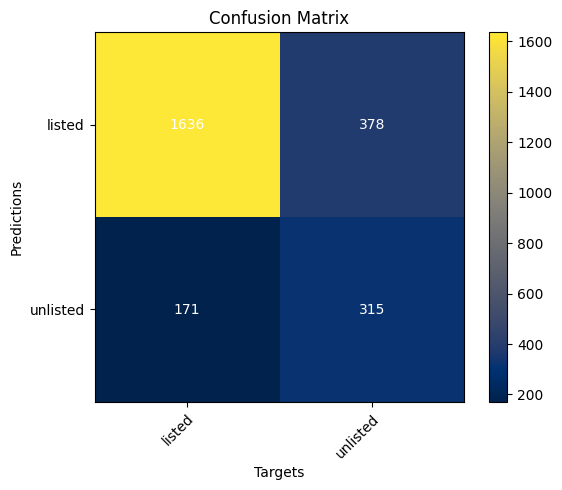

In [17]:
labels = {"listed":0, "unlisted":1}
print(classification_report(y_pred, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

# Extending Features with Reviews

## Preprocessing Reviews

In [18]:
reviews_df = pd.read_csv('output/train_reviews_with_sentiment.csv')

reviews_df['comments'] = reviews_df['comments_no_emoji'].astype('string')
reviews_df = reviews_df.dropna()

grouped = reviews_df.groupby(['index', 'language']).agg({'comments': 'count'})
grouped = grouped.reset_index()
final_grouped = grouped.groupby('index').agg({'language': 'nunique', 'comments': 'sum'})
final_grouped = final_grouped.reset_index()
final_grouped.columns = ['index', 'unique_languages_count', 'total_comments_count'] # rename the columns to the desired names


# Extracting and merging only English revies for now
reviews_df_eng = reviews_df[(reviews_df['language']=='en')]

grouped_eng = reviews_df_eng.groupby(['index']).agg({'comments': ['count', ' '.join]})
grouped_eng.columns = ['_'.join(col).strip() for col in grouped_eng.columns.values]
grouped_eng = grouped_eng.reset_index()

grouped_eng.columns = ['index', 'eng_comment_count', 'eng_reviews_merged'] # Rename the columns of the DataFrame

# Dataset constructed from Reviews
merged_reviews = pd.merge(final_grouped, grouped_eng, on='index', how='left')

# Group by 'index' and calculate median values for sentiments
grouped_sentiment = reviews_df.groupby('index')[
    ['sentiment_TextBlob', 'sentiment_nltk', 'sentiment_distilbert']].median().reset_index()

# Creating the final features for reviews by merging with Sentiment medians
merged_reviews = pd.merge(merged_reviews, grouped_sentiment, on='index', how='left')

merged_reviews.head()

,index,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,7,50,30.0,this is a very cozy and comfortable house to s...,0.280481,0.44905,0.992033
1,5,6,41,17.0,We really enjoyed staying at Sonias place. The...,0.292708,0.20230,-0.597586
2,8,8,168,145.0,Shani was very helpful throughout our process!...,0.422480,0.94500,0.999798
3,9,6,32,16.0,Great little space; lovely hosts - clean and w...,0.298313,0.69305,0.973889
4,10,3,13,11.0,"WOW, what a great stay! The spacious apartment...",0.405238,0.91990,0.999775


In [19]:
# Merging reviews to train_df
train_df = pd.merge(train_df, merged_reviews, on='index', how='left')
train_df.head()

,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",exclusive villa located quiet pinewood area co...,3.0,25.0,21.0,Great house in a great location. Close to Lisb...,0.418750,0.97050,0.999820
1,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",luna house b b part luna house hub located clo...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,newly refurbished apartment swimming pool stun...,3.0,32.0,25.0,Great getaway in cascais. Gorgeous apartment a...,0.370833,0.93830,0.999775
3,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,en,en,Nice studio for two people with one bathroom a...,nice studio two people one bathroom compact ki...,13.0,226.0,146.0,"The studio is very charming, comfortable, has ...",0.320539,0.79285,0.999446
4,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,en,en,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...",whether shorter longer stay want offer solutio...,16.0,523.0,356.0,"I'm portuguese from Lisbon , living in Italy, ...",0.366667,0.86870,0.999623


In [20]:
train_df['eng_reviews_cleaned'] = clean(train_df['eng_reviews_merged'], lemmatize = True, stemmer = False)
train_df.head()

100%|███████████████████████████████████████| 9996/9996 [05:11<00:00, 32.11it/s]


,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert,eng_reviews_cleaned
0,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",exclusive villa located quiet pinewood area co...,3.0,25.0,21.0,Great house in a great location. Close to Lisb...,0.418750,0.97050,0.999820,great house great location close lisbon sintra...
1,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",luna house b b part luna house hub located clo...,NaN,NaN,NaN,,NaN,NaN,NaN,
2,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,newly refurbished apartment swimming pool stun...,3.0,32.0,25.0,Great getaway in cascais. Gorgeous apartment a...,0.370833,0.93830,0.999775,great getaway cascais gorgeous apartment excel...
3,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,en,en,Nice studio for two people with one bathroom a...,nice studio two people one bathroom compact ki...,13.0,226.0,146.0,"The studio is very charming, comfortable, has ...",0.320539,0.79285,0.999446,studio charming comfortable everything need st...
4,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,en,en,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...",whether shorter longer stay want offer solutio...,16.0,523.0,356.0,"I'm portuguese from Lisbon , living in Italy, ...",0.366667,0.86870,0.999623,portuguese lisbon living italy travel often ba...


## Defining non-textual features

In [21]:
non_text_cols = ['description_language', 'host_about_language',
                'unique_languages_count', 'total_comments_count', 'eng_comment_count',
                'sentiment_TextBlob', 'sentiment_nltk', 'sentiment_distilbert']

train_features_df = train_df[non_text_cols].copy()


# Replace 'en' with 1 and others with 0 in 'description_language' and 'host_about_language'
train_features_df['description_language'] = np.where(train_features_df['description_language'] == 'en', 1, 0)
train_features_df['host_about_language'] = np.where(train_features_df['host_about_language'] == 'en', 1, 0)


# Scaling selected columns with StandardScaler
scaler = StandardScaler()
cols_to_scale = ['unique_languages_count', 'total_comments_count', 'eng_comment_count']
train_features_df[cols_to_scale] = scaler.fit_transform(train_features_df[cols_to_scale])


train_features_df.head()

,description_language,host_about_language,unique_languages_count,total_comments_count,eng_comment_count,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert
0,1,1,-1.055532,-0.620620,-0.524006,0.418750,0.97050,0.999820
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,-1.055532,-0.547892,-0.463260,0.370833,0.93830,0.999775
3,1,1,1.856592,1.467723,1.374296,0.320539,0.79285,0.999446
4,1,1,2.730230,4.553484,4.563443,0.366667,0.86870,0.999623


## Defining Features with TF-IDF

In [22]:
train_df.head(3) # this is training dataset merged with "merged english reviews"

,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert,eng_reviews_cleaned
0,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,en,en,"This exclusive villa, located in a quiet pinew...",exclusive villa located quiet pinewood area co...,3.0,25.0,21.0,Great house in a great location. Close to Lisb...,0.418750,0.9705,0.999820,great house great location close lisbon sintra...
1,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,en,en,"Luna House B&B is part of the Luna House Hub, ...",luna house b b part luna house hub located clo...,NaN,NaN,NaN,,NaN,NaN,NaN,
2,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,en,en,Newly refurbished apartment with swimming pool...,newly refurbished apartment swimming pool stun...,3.0,32.0,25.0,Great getaway in cascais. Gorgeous apartment a...,0.370833,0.9383,0.999775,great getaway cascais gorgeous apartment excel...


In [23]:
tfidf_desc = TfidfVectorizer()     
tfidf_reviews = TfidfVectorizer() #(max_features = 1000) 

X_train_1 = tfidf_desc.fit_transform(train_df["cleaned_description"])
X_train_2 = tfidf_reviews.fit_transform(train_df["eng_reviews_cleaned"]) 

print(X_train_1.shape, X_train_2.shape)

(9996, 15179) (9996, 59697)


In [24]:
n1 = X_train_1.shape[1]
n2 = X_train_2.shape[1]
n_additional = len(non_text_cols)

X_train_ext = np.zeros((X_train_1.shape[0], n1 + n2 + n_additional))

In [25]:
X_train_ext[:, :n1] = X_train_1.toarray()  # copy over TF-IDF for cleaned AirBnb description
X_train_ext[:, n1:n1+n2] = X_train_2.toarray()  # copy over TF-IDF for cleaned English reviews
X_train_ext[:, n1+n2:] =  train_features_df.values   # copy over the rest of features from train_features_df

X_train_ext = np.nan_to_num(X_train_ext, nan=0) # filling in empty values with zeroes

X_train_ext.shape

(9996, 74884)

## Processing validation set in the same manner

In [26]:
val_df['cleaned_description'] = clean(val_df['description'], lemmatize = True, stemmer = False)
val_df = pd.merge(val_df, merged_reviews, on='index', how='left')
val_df['eng_reviews_cleaned'] = clean(val_df['eng_reviews_merged'], lemmatize = True, stemmer = False)

val_df.head()

100%|███████████████████████████████████████| 2500/2500 [01:17<00:00, 32.06it/s]


,index,description,host_about,unlisted,description_language,host_about_language,description_english,cleaned_description,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged,sentiment_TextBlob,sentiment_nltk,sentiment_distilbert,eng_reviews_cleaned
0,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,en,en,This charming apartment on the first floor of ...,charming apartment first floor typical cascais...,8.0,54.0,33.0,The host canceled this reservation 233 days be...,0.327273,0.76295,0.998771,host canceled reservation day arrival automate...
1,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,en,en,Charming villa with a private pool and tennis ...,charming villa private pool tennis table withi...,NaN,NaN,NaN,,NaN,NaN,NaN,
2,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,en,en,One bedroom apartment inside a modern developm...,one bedroom apartment inside modern developmen...,10.0,141.0,106.0,"Everything is great and very convenient, the p...",0.371000,0.84490,0.999590,everything great convenient parking place near...
3,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0,en,en,"Apartment in the heart of the city, between Pr...",apartment heart city pr ncipe real chiado bair...,12.0,208.0,144.0,Great apartment! Great location! Great hospita...,0.390972,0.87550,0.999710,great apartment great location great hospitali...
4,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0,en,en,Amazing flat with two bedrooms in Restauradore...,amazing flat two bedroom restauradores lisbon ...,10.0,34.0,21.0,"Very clean, professional and central. Would re...",0.279365,0.65285,0.998494,clean professional central would recommend any...


In [27]:
# Processing non-textual features
val_features_df = val_df[non_text_cols].copy()
val_features_df['description_language'] = np.where(val_features_df['description_language'] == 'en', 1, 0)
val_features_df['host_about_language'] = np.where(val_features_df['host_about_language'] == 'en', 1, 0)

# Scaling
val_features_df[cols_to_scale] = scaler.transform(val_features_df[cols_to_scale])

In [28]:
X_val_1 = tfidf_desc.transform(val_df["cleaned_description"])
X_val_2 = tfidf_reviews.transform(val_df["eng_reviews_merged"])                            
n1 = X_val_1.shape[1]
n2 = X_val_2.shape[1]
n_additional = len(non_text_cols)

X_val_ext = np.zeros((X_val_1.shape[0], n1 + n2 + n_additional))
X_val_ext[:, :n1] = X_val_1.toarray()      # copy over TF-IDF for cleaned AirBnb description
X_val_ext[:, n1:n1+n2] = X_val_2.toarray() # copy over TF-IDF for cleaned English reviews
X_val_ext[:, n1+n2:] = val_features_df.values   # copy over the rest of features from val_features_df
X_val_ext = np.nan_to_num(X_val_ext, nan=0)   # filling in empty values with zeroes                                 

y_val = np.array(val_df['unlisted'])

print(X_val_ext.shape, y_val.shape)

(2500, 74884) (2500,)


## KNN model (on extended list of features)

In [29]:
# Model Building
modelknn = KNeighborsClassifier(n_neighbors = 7, 
                                metric = 'cosine', 
                                weights = 'distance')

modelknn.fit(X_train_ext, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

In [30]:
# Making preditions
y_pred = modelknn.predict(X_val_ext)

              precision    recall  f1-score   support

      listed       0.92      0.91      0.91      1823
    unlisted       0.76      0.78      0.77       677

    accuracy                           0.87      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.87      0.87      0.87      2500



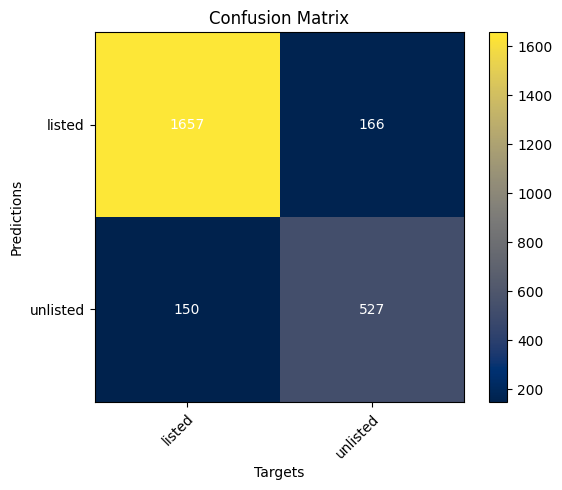

In [31]:
# Model Evaluation
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

## RandomForest (on extended list of features)

In [32]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=100, 
                                      class_weight={0: 0.7, 1: 0.3}, 
                                      random_state=42)

model_forest.fit(X_train_ext, y_train)

RandomForestClassifier(class_weight={0: 0.7, 1: 0.3}, random_state=42)

In [33]:
# Predicting
y_pred = model_forest.predict(X_val_ext)

              precision    recall  f1-score   support

      listed       0.90      0.92      0.91      1764
    unlisted       0.81      0.76      0.78       736

    accuracy                           0.88      2500
   macro avg       0.86      0.84      0.85      2500
weighted avg       0.87      0.88      0.88      2500



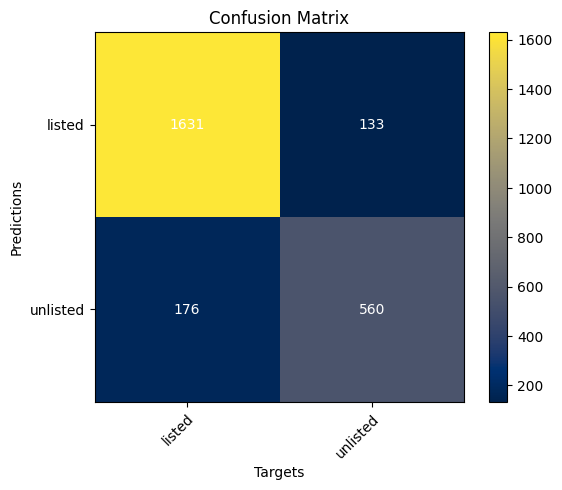

In [34]:
# Evaluation
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

## XGBoost model (on extended list of features)

In [35]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(scale_pos_weight=0.25, random_state=123)
model_xgb.fit(X_train_ext, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

              precision    recall  f1-score   support

      listed       0.96      0.84      0.90      2065
    unlisted       0.53      0.84      0.65       435

    accuracy                           0.84      2500
   macro avg       0.74      0.84      0.77      2500
weighted avg       0.89      0.84      0.85      2500



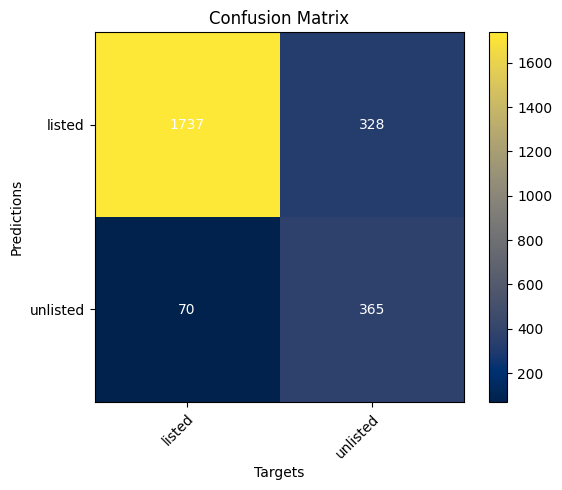

In [36]:
# Predicting
y_pred = model_xgb.predict(X_val_ext)

# Evaluating
print(classification_report(y_pred, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())